# Read and Prepare Data

In [1]:
include("./code/bo.jl")

dfile = "29IH1eBO01.mat"
data,param = readmat("./data/$dfile")

spike = data["cellspike"][1][:]
eye = data["eyepoint"]
minconddur = Int(param["SubjectParam"]["MinCondDur"])
fixrad = param["SubjectParam"]["FPWinRad"]/param["SubjectParam"]["UnitsPerDeg"]
ct=condtest(data["condtests"],param["Condition"]);

 in depwarn at deprecated.jl:73
 in call at deprecated.jl:50
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:304
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:304
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:304
 in require at ./loading.jl:243
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:304
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:304
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at /home/alex/.julia/v0.4/IJulia/src/execute_request.jl:177
 in eventloop at /home/alex/.julia/v0.4/IJulia/src/IJulia.jl:141
 in anonymous at task.jl:447
while loading /home/alex/.julia/v0.4/NeuroAnalysis/src/Core/Graphics.jl, in expression starting on line 187
 in depwarn at deprecated.jl:73
 in call at deprecated.jl:50
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:304
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:304
 in include 

In [3]:
using Compose, Gadfly, Colors, NeuroAnalysis.NAVisualization
ti = find(Array{Bool}(map(x->!isempty(x),ct[:targetontime])))
tgton = float64(ct[ti[1:end-1],:targetontime])
fixon = float64(ct[ti[1:end-1],:fixontime])
fixoff = float64(ct[ti[2:end]-1,:testofftime])

gct = ct[ct[:status] .!= "Early",:]
gfigon = float64(gct[:figontime])
gfigoff = float64(gct[:figofftime])
factors = ["FigSide","EdgeContrast","xRFSize","FigType"]
dataset = deepcopy(gct[:,map(symbol,factors)])
dn = size(dataset,1)
dataset[:cellid] = [param["CellID"] for i=1:dn]
dataset[:testtype] = [param["TestType"] for i=1:dn]
dataset[:testrepeat] = [Int(param["TestRepeat"]) for i=1:dn]
fl = [f=>sort(unique(dataset[symbol(f)])) for f in factors]

set_default_plot_size(22cm,13cm);

# Eye Movement

In [4]:
et,en,ws,is = subrv(eye[:,1],tgton,fixoff,isminzero=true)
ex = map(x->eye[x,2],is);ey = map(x->eye[x,3],is);

Interact.Slider{Int64}(Signal{Int64}(15, nactions=0),"Which Epoch?",15,1:29)

    writemime(Base.IO, Base.Multimedia.MIME, Reactive.Node) at /home/alex/.julia/v0.4/Interact/src/IJulia/setup.jl:99
is ambiguous with: 
    writemime(Base.IO, Base.Multimedia.MIME{:text/plain}, Any) at replutil.jl:4.
To fix, define 
    writemime(Base.IO, Base.Multimedia.MIME{:text/plain}, Reactive.Node)
before the new definition.


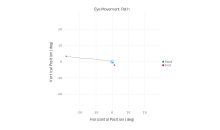

In [5]:
using Reactive, Interact
@manipulate for i=slider(1:length(en),label="Which Epoch?")
lim=ceil(maximum([maximum(abs(ex[i])),maximum(abs(ey[i]))]))
plot(layer(x=[ex[i][1],ex[i][end]],y=[ey[i][1],ey[i][end]],color=["Start","End"],Geom.point,Theme(default_point_size=2.5px,highlight_width=0mm)),
layer(x=ex[i],y=ey[i],Geom.path,Theme(line_width=0.5px,default_color=LCHab(10,50,230))),
Coord.Cartesian(aspect_ratio=1,xmin=-lim,xmax=lim,ymin=-lim,ymax=lim),Scale.color_discrete_manual(colorant"seagreen",colorant"crimson"),
Guide.annotation(compose(context(),circle(0,0,fixrad),fill(nothing),stroke(colorant"deepskyblue"))),Guide.colorkey(""),
Guide.xlabel("Horizontal Position (deg)"),Guide.ylabel("Vertical Position (deg)"),Guide.title("Eye Movement Path"))
end

## Fixational eye movement

In [6]:
et,en,ws,is = subrv(eye[:,1],gfigon,gfigoff,isminzero=true)
ex = map(x->eye[x,2],is);ey = map(x->eye[x,3],is);

Interact.Slider{Int64}(Signal{Int64}(72, nactions=0),"Which Epoch?",72,1:144)

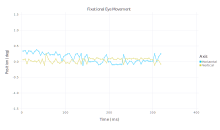

In [7]:
@manipulate for i=slider(1:length(en),label="Which Epoch?")
df=[DataFrame(x=et[i],y=ex[i],Axis=fill("Horizontal",en[i]));DataFrame(x=et[i],y=ey[i],Axis=fill("Vertical",en[i]))]
    plot(df,x=:x,y=:y,color=:Axis,Geom.point,Geom.line,Coord.Cartesian(ymin=-1.5,ymax=1.5),Theme(default_point_size=2px),
    Guide.xlabel("Time (ms)"),Guide.ylabel("Position (deg)"),Guide.title("Fixational Eye Movement"))
end

# Spiking

In [8]:
durex = 200 # ms
st,sn,ws,is = subrv(spike,gfigon-durex,gfigoff+durex,isminzero=true)
st = map(x->x-durex,st)
bin = -durex:10:minconddur+durex
dataset[:spike]=st;

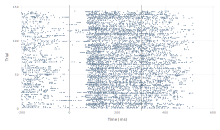

In [9]:
plotspiketrain(st,timemark=[0,minconddur],theme=Theme(default_point_size=1.6px,default_color=RGBA(0.0,0.16,0.32,0.7),highlight_width=0.0px))

# GLM

In [10]:
using GLM
delay = 30 # ms
rend = minconddur
dataset[:response] = subrvr(spike,gfigon,gfigoff,winmin=delay,winmax=rend,isminzero=true,isfiringrate=true)
dataset[:responsecount] = subrvr(spike,gfigon,gfigoff,winmin=delay,winmax=rend,isminzero=true)
dataset[:responsetrans] = anscombe(dataset[:responsecount])
rdataset = deepcopy(dataset[:,[map(symbol,factors),:responsetrans,:responsecount]])
pool!(rdataset,map(symbol,factors))
lmout = lm(responsetrans ~ FigSide + EdgeContrast + xRFSize + FigType
+ FigSide&EdgeContrast + FigSide&xRFSize + FigSide&FigType + EdgeContrast&xRFSize + EdgeContrast&FigType + xRFSize&FigType
+ FigSide&EdgeContrast&xRFSize + FigSide&EdgeContrast&FigType + EdgeContrast&xRFSize&FigType
+ FigSide&EdgeContrast&xRFSize&FigType
,rdataset)

DataFrames.DataFrameRegressionModel{GLM.LinearModel{GLM.DensePredQR{Float64}},Float64}:

Coefficients:
                                                                       Estimate Std.Error   t value Pr(>|t|)
(Intercept)                                                             9.76705  0.427566   22.8434   <1e-45
FigSide - 1                                                             2.82258  0.540832   5.21896    <1e-6
EdgeContrast - 1                                                      -0.105791  0.634182 -0.166815   0.8678
xRFSize - 6                                                            -2.75537  0.540832  -5.09468    <1e-5
FigType - Overlapping                                                 0.0375498  0.573639 0.0654588   0.9479
FigType - CShape                                                       -1.50935  0.573639  -2.63118   0.0096
FigSide - 1 & EdgeContrast - 1                                         0.802003  0.855131  0.937871   0.3502
FigSide - 1 & xRFSize - 6

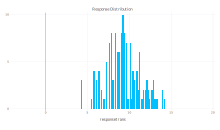

In [11]:
rlim=20
plot(dataset,x=:responsetrans,xintercept=[0],Geom.vline(color="gray",size=1pt),Geom.histogram(bincount=100),
Coord.Cartesian(xmin=-rlim/5,xmax=rlim),Guide.title("Response Distribution"))

In [12]:
glmout = glm(responsecount ~ FigSide + EdgeContrast + xRFSize + FigType
+ FigSide&EdgeContrast + FigSide&xRFSize + FigSide&FigType + EdgeContrast&xRFSize + EdgeContrast&FigType + xRFSize&FigType
+ FigSide&EdgeContrast&xRFSize + FigSide&EdgeContrast&FigType + EdgeContrast&xRFSize&FigType
+ FigSide&EdgeContrast&xRFSize&FigType
,rdataset,Poisson(),SqrtLink())

DataFrames.DataFrameRegressionModel{GLM.GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Distributions.Poisson,GLM.SqrtLink},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Float64}:

Coefficients:
                                                                        Estimate Std.Error   z value Pr(>|z|)
(Intercept)                                                              4.86819  0.186339   26.1254   <1e-99
FigSide - 1                                                              1.41674  0.235702   6.01072    <1e-8
EdgeContrast - 1                                                      -0.0723536  0.276385 -0.261785   0.7935
xRFSize - 6                                                             -1.36713  0.235702  -5.80022    <1e-8
FigType - Overlapping                                                   0.036208      0.25  0.144832   0.8848
FigType - CShape                                                       -0.761647      0.25  -3.04659   0.0023
Fi

# PSTH

Interact.Options{:ToggleButtons,ASCIIString}(Signal{ASCIIString}(FigSide, nactions=0),"","FigSide","FigSide",Interact.OptionDict(Any["FigSide","EdgeContrast","xRFSize","FigType"],Dict{Any,Any}("EdgeContrast"=>"EdgeContrast","FigType"=>"FigType","xRFSize"=>"xRFSize","FigSide"=>"FigSide")),Any[],Any[])

Signal{ASCIIString}(FigSide, nactions=1)

  likely near In[13]:3
  likely near In[13]:3
  likely near In[13]:3


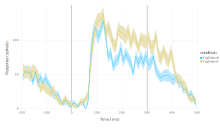

In [13]:
f = togglebuttons(factors)
display(f)
@manipulate for f=signal(f)
    plotpsth(dataset,bin,flcond(fl,f),timemark=[0,minconddur])
end

In [15]:
f1 = togglebuttons(factors)
display(f1)
f2 = lift(x->togglebuttons(filter(a->a!=x,factors)),f1)
display(f2)
@manipulate for f1=f1.signal,f2=f2.value.signal
    plotpsth(dataset,bin,flcond(fl,f1,f2),timemark=[0,minconddur])
end

Interact.Options{:ToggleButtons,ASCIIString}(Signal{ASCIIString}(FigSide, nactions=0),"","FigSide","FigSide",Interact.OptionDict(Any["FigSide","EdgeContrast","xRFSize","FigType"],Dict{Any,Any}("EdgeContrast"=>"EdgeContrast","FigType"=>"FigType","xRFSize"=>"xRFSize","FigSide"=>"FigSide")),Any[],Any[])

LoadError: LoadError: MethodError: `lift` has no method matching lift(::Function, ::Interact.Options{:ToggleButtons,ASCIIString})
Closest candidates are:
  lift(::Any, !Matched::Reactive.Node{T}...)
while loading In[15], in expression starting on line 3

In [ ]:
f1 = togglebuttons(factors)
display(f1)
f2 = lift(x->togglebuttons(filter(a->a!=x,factors)),f1)
display(f2)
@manipulate for f1=f1.signal,f2=f2.value.signal
    df,ss = psth(dataset,bin,flcond(fl,f1,f2))
    df[:f1] = map(x->contains(x,"$(f1)=0")?"$(f1)=0":"$(f1)=1",df[:condition])
    df[:f2] = map(x->contains(x,"$(f2)=0")?"$(f2)=0":"$(f2)=1",df[:condition])
    plot(df,x=:x,y=:y,ymin=:ymin,ymax=:ymax,xintercept=fill(0,size(df,1)),color=:f1,xgroup=:f2,
    Geom.subplot_grid(Geom.line,Geom.ribbon,Geom.vline(color="gray",size=1pt),free_x_axis=true),
    Guide.xlabel("Time (ms)"),Guide.ylabel("Response (spike/s)"))
end

In [ ]:
include("./code/plot.jl")
sdi = (dataset[:xRFSize].==3) & (dataset[:FigType].=="SingleSqr")
f1="FigSide";f2="EdgeContrast"
ps = f1psthf2(dataset[sdi,:],bin,fl,f1,f2,timemark=[0,minconddur],xmax=minconddur+200,ymax=300);

In [ ]:
savefigs(ps,path="./figure")

In [ ]:
bopsth = d->begin
    df,ss = psth(d,bin,conds)
    x = df[df[:condition].==ss[1],:x]
    y0=df[df[:condition].==ss[1],:y]-df[df[:condition].==ss[2],:y]
    y1=df[df[:condition].==ss[3],:y]-df[df[:condition].==ss[4],:y]
    #m0 = DataFrame(x=df[df[:condition].==ss[1],:x],y=df[df[:condition].==ss[1],:y]-df[df[:condition].==ss[2],:y],condition="$(conds[1][1][1])$(conds[1][1][2]) - $(conds[1][1][1])$(conds[2][1][2]), $(conds[1][2][1])=$(conds[1][2][2])")
#m1 = DataFrame(x=df[df[:condition].==ss[1],:x],y=df[df[:condition].==ss[3],:y]-df[df[:condition].==ss[4],:y],condition="$(conds[1][1][1])$(conds[1][1][2]) - $(conds[1][1][1])$(conds[2][1][2]), $(conds[3][2][1])=$(conds[3][2][2])")
    return x,y0,y1
end
function cboot(d,fun,m)
    n = size(d,1)
    x,y0,y1 = fun(d)
    #t0 = Array(typeof(y0), m)
    #t1 = Array(typeof(y1), m)
    t0 = Array(Vector{Float64}, m)
    t1 = Array(Vector{Float64}, m)
    for i in 1:m
        x,t0[i],t1[i] = fun(d[sample(1:n, n),:])
    end
    return x,t0,t1
end
x,t0,t1 = cboot(dataset,bopsth,3000)
function hmatrix{T}(hv::Vector{Vector{T}})
    tn=length(hv)
    bn = length(hv[1])
    hm=Array(T,tn,bn)
    for i in 1:tn
        hm[i,:]=hv[i]
    end
    return hm
end
mt0=hmatrix(t0)
mt1=hmatrix(t1)
ph = x->begin
  n = size(x,1)
  m = mean(x,1)[:]
  sd = std(x,1)[:]
  return m,sd,n
end
m0,sd0,n0=ph(mt0)
m1,sd1,n1=ph(mt1);

In [ ]:
m0df = DataFrame(x=x,y=m0,ymin=m0-sd0,ymax=m0+sd0,condition="$(conds[1][1][1])$(conds[1][1][2]) - $(conds[1][1][1])$(conds[2][1][2]), $(conds[1][2][1])=$(conds[1][2][2])")
m1df = DataFrame(x=x,y=m1,ymin=m1-sd1,ymax=m1+sd1,condition="$(conds[1][1][1])$(conds[1][1][2]) - $(conds[1][1][1])$(conds[2][1][2]), $(conds[3][2][1])=$(conds[3][2][2])")
plot([m0df,m1df],x=:x,y=:y,ymin=:ymin,ymax=:ymax,color=:condition,xintercept=[0],
    Geom.line,Geom.ribbon,Geom.vline(color="gray",size=1pt),
    Coord.Cartesian(xmin=bin[1],xmax=bin[end]),Guide.xlabel("Time (ms)"),Guide.ylabel("Response (spike/s)"))

In [ ]:
m0 = DataFrame(x=df[df[:condition].==ss[1],:x],y=df[df[:condition].==ss[1],:y]-df[df[:condition].==ss[2],:y],condition="$(conds[1][1][1])$(conds[1][1][2]) - $(conds[1][1][1])$(conds[2][1][2]), $(conds[1][2][1])=$(conds[1][2][2])")
m1 = DataFrame(x=df[df[:condition].==ss[1],:x],y=df[df[:condition].==ss[3],:y]-df[df[:condition].==ss[4],:y],condition="$(conds[1][1][1])$(conds[1][1][2]) - $(conds[1][1][1])$(conds[2][1][2]), $(conds[3][2][1])=$(conds[3][2][2])")
plot([m0,m1],x=:x,y=:y,color=:condition,xintercept=[0],
    Geom.line,Geom.ribbon,Geom.vline(color="gray",size=1pt),
Coord.Cartesian(xmin=bin[1],xmax=bin[end]),Guide.xlabel("Time (ms)"),Guide.ylabel("Response (spike/s)"))